In [73]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

In [74]:
%%time
BES_Panel   = pd.read_stata( BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
print("BES_Panel", BES_Panel.shape )
BES_numeric = pd.read_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )
print("BES_numeric",  BES_numeric.shape )
var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

BES_Panel (31409, 733)
BES_numeric (31409, 659)
var_type (733, 1)
Wall time: 12.8 s


In [75]:
fname = BES_data_folder+"cat_dictionary"+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

In [76]:
# BES_imputed = pd.read_hdf( BES_data_folder+"BESW8median.hdf", "BESW8median")
# BES_imputed = pd.read_hdf(BES_data_folder+"BESW8softimpute.hdf","BESW8softimpute")
BES_imputed = pd.read_hdf( BES_data_folder+"BESW8mice.hdf", "BESW8mice" )
print("BES_imputed",  BES_imputed.shape )

BES_imputed (31409, 378)


In [77]:
England_inds = BES_Panel[BES_Panel["country"]=="England"].index
print ( "respondents not from England: ", len(BES_Panel) - len(England_inds) )
Remain_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==0 ].index
Leave_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==1 ].index
Notvoters_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==2 ].index
Dontknow_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==3 ].index
print ( "respondents not Remain/Leave: ", len(BES_Panel) - len(Remain_inds) - len(Leave_inds) )
Leave_Remain_inds = pd.Index( np.concatenate( (Leave_inds, Remain_inds), axis=0 ) )
EngRemLea_inds = pd.Index( np.intersect1d( England_inds, Leave_Remain_inds ) )


respondents not from England:  11944
respondents not Remain/Leave:  2344


In [78]:
W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])
print ( "W9 columns: ", W9_vars )

opts_per_cat = BES_numeric.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()

many_cat_drop_list = opts_per_cat[opts_per_cat>30].index
# many_cat_drop_list = ['profile_lea', 'profile_oslaua', 'EUMIICategory']
print("many_cat_drop_list", many_cat_drop_list )

W9 columns:  Index(['generalElectionVoteW9', 'partyIdW9', 'partyIdSqueezeW9',
       'partyIdEUretroW9', 'BESwave9_SamplesurveyW9', 'bestOnMIIW9',
       'euRefTurnoutRetroW9', 'euRefVoteHypotheticalW9', 'euRefVoteW9',
       'voteMethodW9',
       ...
       'polKnowPutinW9', 'polKnowMerkelW9', 'polKnowAssadW9',
       'selfOccSuperviseW9', 'selfOccOrgSizeW9', 'selfOccEmployeesW9',
       'selfOccSuperviseLastW9', 'selfOccOrgSizeLastW9',
       'selfOccEmployeesLastW9', 'anyUniW9'],
      dtype='object', length=209)
many_cat_drop_list Index(['ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano'],
      dtype='object')


In [12]:
# %%time
# counts = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count()
# counts_by_individuals = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [13]:
# drop people who are coverage outliers
# say top and bottom 5%
# BES_red = BES_numerics_only.loc[BES_reduced["wave9"]==1 ].copy()


In [14]:
# thresh = .00
# BES_red = BES_numeric.copy()
# BES_red["coverage"] = BES_numeric.count(axis=1)/BES_numeric.shape[1]

# outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
#                          ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
# inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
#                          ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

(array([  5.00000000e+00,   2.00000000e+01,   2.00000000e+01,
          2.50000000e+01,   2.40000000e+01,   3.70000000e+01,
          5.70000000e+01,   4.80000000e+01,   4.30000000e+01,
          6.20000000e+01,   9.20000000e+01,   7.70000000e+01,
          1.13000000e+02,   1.33000000e+02,   1.49000000e+02,
          1.95000000e+02,   2.38000000e+02,   2.81000000e+02,
          5.05000000e+02,   6.67000000e+02,   6.06000000e+02,
          6.34000000e+02,   7.45000000e+02,   8.85000000e+02,
          8.66000000e+02,   8.76000000e+02,   6.01000000e+02,
          5.77000000e+02,   6.99000000e+02,   7.70000000e+02,
          1.02200000e+03,   1.51100000e+03,   1.83100000e+03,
          2.29500000e+03,   2.64400000e+03,   2.79200000e+03,
          2.58700000e+03,   2.30400000e+03,   1.52100000e+03,
          1.19100000e+03,   6.49000000e+02,   4.72000000e+02,
          2.51000000e+02,   1.42000000e+02,   6.80000000e+01,
          3.60000000e+01,   2.10000000e+01,   1.70000000e+01,
        

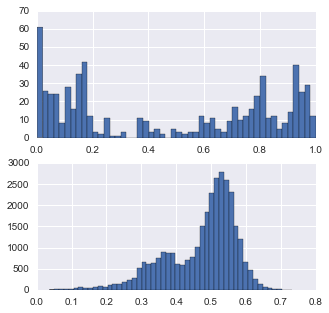

In [80]:
counts = BES_numeric.count()/BES_numeric.shape[0] # super slow!
counts_by_individuals = BES_numeric.count(axis=1)/BES_numeric.shape[1] # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=50)
axarr[1].hist(counts_by_individuals,bins=50)

In [81]:
thresh = 0.33

mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index

In [82]:
BES_min = BES_numeric[mostly_filled_out]
print(BES_min.shape)
missing_fraction = BES_min.isnull().sum().sum()/(BES_min.shape[0]*BES_min.shape[1])
print(missing_fraction)

(31409, 362)
0.2223548024117379


Wall time: 6min 5s


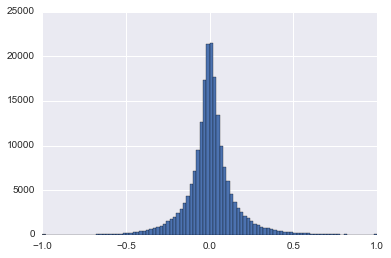

In [83]:
%%time
data = BES_numeric
corr_mat = data.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [84]:
corr_df = pd.DataFrame(columns = ["var1","var2","corr","var1%","var2%","min var%"])
# min_corr = []
id_num = 0

min_filled_out = 0.02

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = data[a].notnull().mean()
    d = data[b].notnull().mean()
    mincd = min(c,d)
    if mincd > min_filled_out and (a not in W9_vars) and (b not in W9_vars):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1


x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = data[a].notnull().mean()
    d = data[b].notnull().mean()
    mincd = min(c,d)
    if (mincd > min_filled_out) and (a not in W9_vars) and (b not in W9_vars):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1
#     print( ( a,b,corr_mat[a][b], c, d, min(c,d) ) )
#     min_corr.append( min(c,d) )
corr_df

,var1,var2,corr,var1%,var2%,min var%
0,euRefVote,euRefVotePost,1.000000,0.925372,0.125092,0.125092
1,partyContactUKIP_3,partyContactLD_3,1.000000,0.025439,0.024070,0.024070
2,euID,euRefVote,0.957034,0.159254,0.925372,0.159254
3,euRefVoteUnsqueeze,euRefVote,1.000000,0.756025,0.925372,0.756025
4,euRefVoteUnsqueeze,euID,0.965933,0.756025,0.159254,0.159254
5,euRefVote2,euRefVote,1.000000,0.800280,0.925372,0.800280
6,euRefVote2,euID,0.960398,0.800280,0.159254,0.159254
7,euRefVote2,euRefVoteUnsqueeze,1.000000,0.800280,0.756025,0.756025
8,ageGroup,age,0.975992,0.628896,1.000000,0.628896
9,Age,age,0.998577,0.807921,1.000000,0.807921


In [85]:
# corr_df.loc[~w9_rows,"min var%"][corr_df["min var%"]>.02].hist(bins=200)

In [86]:
# w9_rows = corr_df["var1"].apply(lambda x: x in W9_vars) | corr_df["var2"].apply(lambda x: x in W9_vars)
# corr_df.loc[~w9_rows][corr_df["min var%"]>.02]

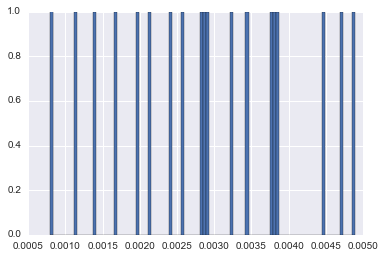

In [87]:
## TEST VARIANCES
a = BES_imputed.var()
b = a<a.quantile(.05)
a[b].hist(bins=100)
very_low_var = BES_imputed.columns[b]
# a.quantile(.01)

In [88]:
# drop columns below certain % filled out (2%)
# drop columns which are identical (drop least filled in) or directly derived
# make a list of derived columns??? -> scales

# WHAT TO REMOVE?
# W9_vars

# two_opt_cats

# many_cat_drop_list
# high_corr_drop_list

# mostly_not_filled_out
# mostly_filled_out

In [89]:
high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
                       'ageGroup', 'Age', 'voted2015', "ns_sec" , 'recallVote15']

In [90]:
BES_reduced = BES_imputed.copy()
cols = BES_reduced.columns
print(BES_reduced.shape)

BES_reduced.drop(W9_vars,axis=1,errors='ignore',inplace=True)
print("W9_vars", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(many_cat_drop_list,axis=1,errors='ignore',inplace=True)
print("many_cat_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(high_corr_drop_list,axis=1,errors='ignore',inplace=True)
print("high_corr_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(mostly_not_filled_out,axis=1,errors='ignore',inplace=True)
print("mostly_not_filled_out", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

BES_reduced.drop(very_low_var,axis=1,errors='ignore',inplace=True) 
print("very_low_var", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

(31409, 378)
W9_vars (31409, 378)
many_cat_drop_list (31409, 378)
high_corr_drop_list (31409, 378)
mostly_not_filled_out (31409, 239)
very_low_var (31409, 239)


In [91]:
def float_2_categorical(series,cat_dict):
    ser = series.astype('int')
    ser = ser.apply( lambda x : min( x , len( cat_dict ) - 1) )
    ser = ser.apply( lambda x : max( x , 0 ) )
    ser = ser.apply( lambda x: cat_dict[x] )  
    return ser


In [92]:
non_ordinal_list = var_type[ var_type["type"]==3 ].index.intersection(BES_reduced.columns)
for non_ordinal in non_ordinal_list:
    BES_reduced[non_ordinal] = float_2_categorical(BES_reduced[non_ordinal],
                                                   cat_dictionary[non_ordinal])
    
BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list )    

In [93]:
# non_ordinal
# cat_dictionary[non_ordinal]
# BES_numeric[non_ordinal].value_counts()
# a = round(BES_reduced[non_ordinal])\
#     .astype('int')
# a.value_counts()
# BES_reduced

In [94]:
two_opt_cats = opts_per_cat[opts_per_cat==2].index.intersection(BES_reduced.columns)
for col in two_opt_cats:
    BES_reduced[col] = BES_reduced[col]\
    .astype('int').apply( lambda x: cat_dictionary[col][x] )\
    .astype('category').cat.reorder_categories(cat_dictionary[col])
    
BES_reduced = pd.get_dummies( BES_reduced, columns=two_opt_cats, drop_first=True )        

In [95]:
ordinal_list = var_type[ var_type["type"].apply(lambda x: x in [1,2,5]) ].index.intersection(BES_reduced.columns)
for ordinal in ordinal_list:
    new_col_name = ordinal + "__" + (cat_dictionary[ordinal])[-1:][0]
    BES_reduced.rename(columns={ordinal:new_col_name}, inplace=True)
    
print("BES_reduced",BES_reduced.shape)

BES_reduced (31409, 456)


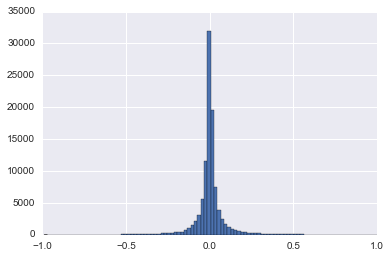

In [96]:
## TEST CORRELATIONS
data = BES_reduced
corr_mat = data.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [97]:
thresh = .05
x = ( ( corr_mat>(1-thresh) ) & mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], data[a].notnull().mean(), data[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) & mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], data[a].notnull().mean(), data[b].notnull().mean() ) )    

('gor_Scotland', 'country_Scotland', 0.99954644599186537, 1.0, 1.0)
('gor_Wales', 'country_Wales', 0.99900576345247805, 1.0, 1.0)
('polKnowMiliband_Leader of the Labour Party', 'polKnowMiliband_Deputy Prime Minister', -0.98958109200004518, 1.0, 1.0)
('polKnowMay_Leader of the Labour Party', 'polKnowMay_Home secretary', -0.96769362990241359, 1.0, 1.0)
('polKnowBercow_Speaker of the House of Commons', 'polKnowBercow_Home secretary', -0.98728882747788815, 1.0, 1.0)


In [98]:
# high_corr_drop_list = ['country_Scotland', 'country_Wales', 'polKnowMay_Leader of the Labour Party',
                      # 'polKnowBercow_Home secretary', 'polKnowMiliband_Deputy Prime Minister']

dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales']
BES_reduced.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
print("dummy_cat_high_corr_drop_list", BES_reduced.shape)
print(dummy_cat_high_corr_drop_list)

dummy_cat_high_corr_drop_list (31409, 454)
['country_Scotland', 'country_Wales']


In [99]:
# very_low_var
# NoiseVariance.loc[very_low_var].sort_values(by='noise_variance_')fc

# upshot - get rid of 

In [100]:
BES_reduced.to_hdf(BES_data_folder+"BES_reduced.hdf","BES_reduced")

In [ ]:
# You need to standardise the data first!

# http://yeolab.github.io/flotilla/docs-stable/_modules/flotilla/compute/infotheory.html

def binify(df, bins):
    """Makes a histogram of each column the provided binsize

    Parameters
    ----------
    data : pandas.DataFrame
        A samples x features dataframe. Each feature (column) will be binned
        into the provided bins
    bins : iterable
        Bins you would like to use for this data. Must include the final bin
        value, e.g. (0, 0.5, 1) for the two bins (0, 0.5) and (0.5, 1).
        nbins = len(bins) - 1

    Returns
    -------
    binned : pandas.DataFrame
        An nbins x features DataFrame of each column binned across rows
    """
    if bins is None:
        raise ValueError('Must specify "bins"')
    binned = df.apply(lambda x: pd.Series(np.histogram(x, bins=bins)[0]))
    binned.index = bin_range_strings(bins)

    # Normalize so each column sums to 1
    binned = binned / binned.sum().astype(float)
    return binned


def entropy(binned, base=2):
    """Find the entropy of each column of a dataframe

    Parameters
    ----------
    binned : pandas.DataFrame
        A nbins x features DataFrame of probability distributions, where each
        column sums to 1
    base : numeric
        The log-base of the entropy. Default is 2, so the resulting entropy
        is in bits.

    Returns
    -------
    entropy : pandas.Seires
        Entropy values for each column of the dataframe.
    """
    return -((np.log(binned) / np.log(base)) * binned).sum(axis=0)